In [1]:
# load packages
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pcntoolkit as pcn
import pickle

from scipy.stats import shapiro

from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical, plot_subcortical
from enigmatoolbox.utils.useful import reorder_sctx

from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix

ext_scripts_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/scripts')
os.chdir(ext_scripts_dir)

from nm_utils import remove_bad_subjects, load_2d

code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)

# importing custom functions
import clinics_desc_functions as custom
from clinics_desc_functions import prepare_data, plot_quality, trajectory_plotting, dk_roi_viz, load_clinics, en_qc, pretrained_adapt_small, set_seed

# set seed
set_seed()

# formatiing
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}


Random seed 42 has been set.


In [2]:
# where things are
main_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO')
models_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/zscores_comparison_long')
os.makedirs(models_dir, exist_ok=True)
controls_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/control_stability_long')
patients_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long')
cdata_dir = ('/home/barbora/Documents/Projects/2021_06_AZV_ESO/data')
fsdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/fs_stats')
bdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/backup/fit_external_long')
images_dir = os.path.join(models_dir,'img')
os.makedirs(images_dir, exist_ok=True)
pretrained_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts')

In [3]:
# get basic parameters for pretrained models
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

In [4]:
###
# longitudinal paired controls
###
#v11_cf = custom.idp_concat(os.path.join(main_dir,'models','adaptation_comparison_paired','V1'), 'v1_Z.txt', idp_ids,  'v11_cont_z.csv', t_dir= models_dir)
#v12_cf = custom.idp_concat(os.path.join(main_dir,'models','adaptation_comparison_paired','V1'), 'v2_Z.txt', idp_ids,  'v12_cont_z.csv', t_dir= models_dir)

v11_cf = custom.idp_concat(controls_dir, 'v1_Z.txt', idp_ids,  'v11_cont_z.csv', t_dir= models_dir)
v12_cf = custom.idp_concat(controls_dir, 'v2_Z.txt', idp_ids,  'v12_cont_z.csv', t_dir= models_dir)

# concatenate over idps and load
v1_cont_z = pd.read_csv(v11_cf, sep = ' ', index_col=0)
v2_cont_z = pd.read_csv(v12_cf, sep = ' ', index_col=0)

# load original control data with clinics
v1_cont_clin = pd.read_csv(os.path.join(controls_dir,'v1_common.csv'),index_col=0, sep = ' ', usecols=range(0,9))
v2_cont_clin = pd.read_csv(os.path.join(controls_dir,'v2_common.csv'),index_col=0, sep = ' ', usecols=range(0,9))

v1_cont_orig = pd.read_csv(os.path.join(controls_dir,'v1_common.csv'),index_col=0, sep = ' ')
v2_cont_orig = pd.read_csv(os.path.join(controls_dir,'v2_common.csv'),index_col=0, sep = ' ')

# change index before concatenation
v1_cont_z.index = v1_cont_clin.index
v2_cont_z.index = v2_cont_clin.index

# concatenate
v1_cont = pd.concat([v1_cont_clin,v1_cont_z],axis=1,join='inner')
v2_cont = pd.concat([v2_cont_clin,v2_cont_z],axis=1,join='inner')


In [5]:
###
# patients
###

v11_pf = custom.idp_concat(os.path.join(patients_dir,'V1'), 'Z_predict.txt', idp_ids,  'v11_pat_z.csv', t_dir= models_dir)
v12_pf = custom.idp_concat(os.path.join(patients_dir,'V2'), 'Z_predict.txt', idp_ids,  'v12_pat_z.csv', t_dir= models_dir)

# concatenate over idps and load
v1_pat_z = pd.read_csv(v11_pf, sep = ' ', index_col=0)
v2_pat_z = pd.read_csv(v12_pf, sep = ' ', index_col=0)

# load clinics
v1_pat_clin = pd.read_csv(os.path.join(patients_dir,'v1_pat.txt'), sep=' ', index_col=0, usecols=range(0,9))
v2_pat_clin = pd.read_csv(os.path.join(patients_dir,'v2_pat.txt'), sep=' ', index_col=0, usecols=range(0,9))

v1_pat_orig_all = pd.read_csv(os.path.join(patients_dir,'v1_pat.txt'), sep=' ', index_col=0)
v2_pat_orig_all = pd.read_csv(os.path.join(patients_dir,'v2_pat.txt'), sep=' ', index_col=0)

# DON'T RUN FOR LONGIT DATA
# delete visit from index
#v1_pat_clin.index = v1_pat_clin.index.str.slice_replace(start=-2, repl='').to_numpy()
#v2_pat_clin.index = v2_pat_clin.index.str.slice_replace(start=-2, repl='').to_numpy()
#v1_pat_orig_all.index = v1_pat_orig_all.index.str.slice_replace(start=-2, repl='').to_numpy()
#v2_pat_orig_all.index = v2_pat_orig_all.index.str.slice_replace(start=-2, repl='').to_numpy()

# change index before concatenation
v1_pat_z.index = v1_pat_clin.index
v2_pat_z.index = v2_pat_clin.index

# concatenate
v1_pat_all = pd.concat([v1_pat_clin,v1_pat_z],axis=1,join='inner')
v2_pat_all = pd.concat([v2_pat_clin,v2_pat_z],axis=1,join='inner')

# We only want to keep patients with both visits
common = v1_pat_all.index.intersection(v2_pat_all.index)
v1_common_id = np.where(v1_pat_all.index.isin(common))
v2_common_id = np.where(v2_pat_all.index.isin(common))

v1_pat = v1_pat_all.loc[common]
v2_pat = v2_pat_all.loc[common]

v1_pat_orig = v1_pat_orig_all.loc[common]
v2_pat_orig = v2_pat_orig_all.loc[common]

delta_pat = v2_pat['age']-v1_pat['age']




In [6]:
v1_pat.to_csv(os.path.join(models_dir, 'v1_pat.txt'), sep=' ', header=True, index=True)
v2_pat.to_csv(os.path.join(models_dir, 'v2_pat.txt'), sep=' ', header=True, index=True)
v1_cont.to_csv(os.path.join(models_dir, 'v1_cont.txt'), sep=' ', header=True, index=True)
v2_cont.to_csv(os.path.join(models_dir, 'v2_cont.txt'), sep=' ', header=True, index=True)

In [7]:
col_comp_id = np.where(v1_pat.columns.isin(idp_ids))[0]

In [8]:
def simple_sig(cont_diff, pat_diff, idp_ids):
    from scipy.stats import norm
    pat_sig = np.empty_like(pat_diff)
 
    for n_idp, idp in enumerate(idp_ids):
        pat_sig[:,n_idp] = 1 - norm(loc = cont_diff[idp].mean(), scale = cont_diff[idp].var()).cdf(abs(pat_diff[idp]))

    df_pat_sig = pd.DataFrame(pat_sig, columns=v1_pat.columns[col_comp_id], index=pat_diff.index)
    return(df_pat_sig)

In [9]:
def nn_deltat_sig(cont_diff, pat_diff, a1, a2, idp_ids):
    from scipy.stats import norm
    pat_sig = np.empty_like(pat_diff)
 
    for n_idp, idp in enumerate(idp_ids):
        pat_sig[:,n_idp] = 1 - norm(loc = 0, 
                                    scale = (cont_diff[idp].var()**2)/((a2-a1)**2)).cdf(abs(pat_diff[idp]))

    df_pat_sig = pd.DataFrame(pat_sig, columns=v1_pat.columns[col_comp_id], index=pat_diff.index)
    return(df_pat_sig)

In [10]:
# Finally, compute the differences
col_comp_id = np.where(v1_pat.columns.isin(idp_ids))[0]
cont_diff = (v2_cont.iloc[:,col_comp_id]) - (v1_cont.iloc[:,col_comp_id])
pat_diff = (v2_pat.iloc[:,col_comp_id]) - (v1_pat.iloc[:,col_comp_id])

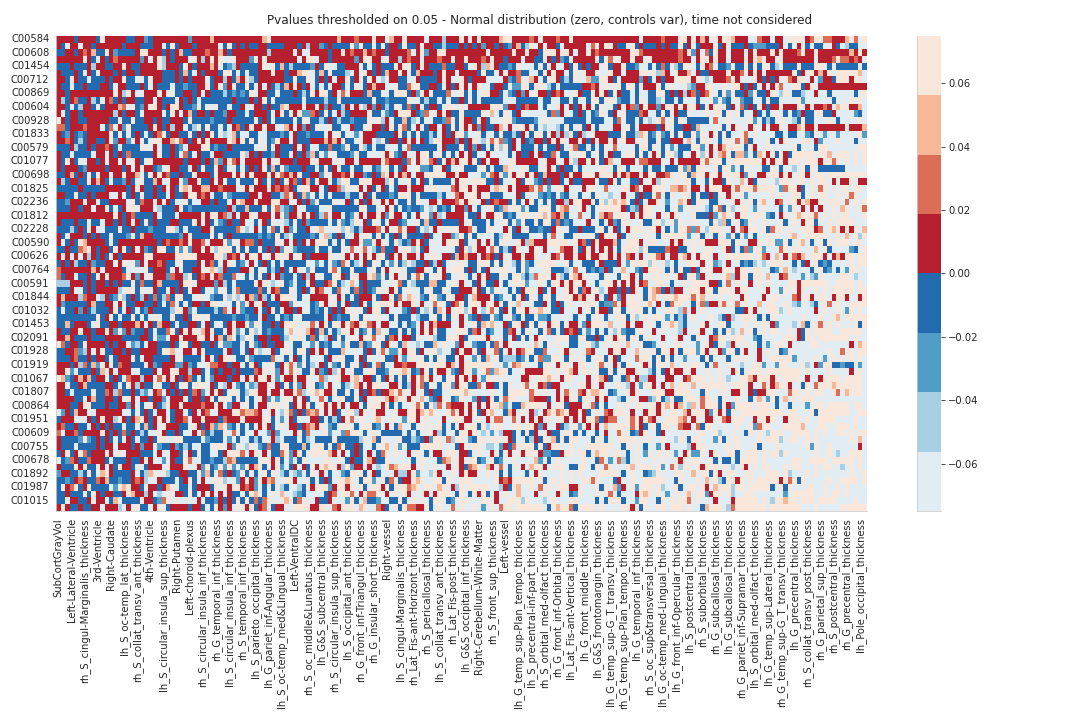

In [30]:
# and significance of differences
# parameters of normal distribution are taken from controls
df_pat_sig = simple_sig(cont_diff, cont_diff, idp_ids)

reordered_heatmap(df_pat_sig, 
                    title = 'Pvalues thresholded on 0.05 - Normal distribution (zero, controls var), time not considered', 
                    savename = os.path.join(models_dir,'heatmap_pvals_notdetrended_noalphashift_notime'),
                    range = cont_diff)


In [19]:
df_pat_sig = nn_deltat_sig(cont_diff, pat_diff, v1_pat['age'], v2_pat['age'],  idp_ids)

reordered_heatmap(df_pat_sig, 
                    title = 'Pvalues thresholded on 0.05 - Normal distribution (zero, controls var), time considered', 
                    savename = os.path.join(models_dir,'heatmap_pvals_notdetrended_noalphashift_time'))


NameError: name 'reordered_heatmap' is not defined

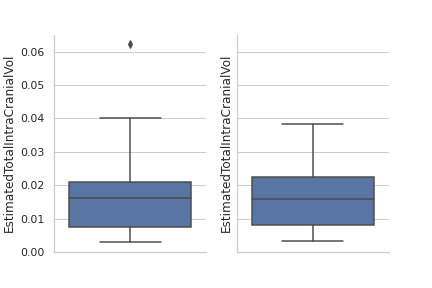

In [66]:
fig, ax = plt.subplots(1,2, sharey=True)
sns.boxplot(y=cont_diff['EstimatedTotalIntraCranialVol'], ax=ax[0], orient='v')
sns.boxplot(y=pat_diff['EstimatedTotalIntraCranialVol'], ax=ax[1], orient='v')
sns.despine()
plt.show()


In [70]:
(v2_pat['age']-v1_pat['age']).mean()

1.1278991596638661

In [26]:
def empirical_dist(x, a1, a2, vec, **kwargs):
    """
    Returns the pvalue of empirical distribution of vector vec (pd series vec) based on value x and time computed from ages (a1, a2)
    the statistic is: 
    alpha = x/(a2-a1)

    we are testing whether alpha is different from zero... for now
    p = empirical_dist(x, vec)
    """
    shift = kwargs.get('shift', 0)    
    alpha = (x)/(a2-a1)
    vec = vec-vec.mean()

    if shift == 0:
        st = (alpha<=vec).sum()/max(vec.shape)
        p = 1- max(np.array([st, 1-st]))
    elif shift > 0:
        st = (alpha>=(vec+shift)).sum()/max(vec.shape)
        p = 1- st
    elif shift < 0:
        st = (alpha<=(vec+shift)).sum()/max(vec.shape)
        p = 1- st

    return (p)

In [27]:
def reordered_heatmap(empir_pvals, **kwargs):
    """Function takes pandas dataframe and returns back the same one, just reordered
    () = reordered heatmap(emmpir_pvals, **kwargs)
        title... figure title
        savename... save name - has to be the entire path!
    """

    # Playing around with row and columns reodering for plotting
    title = kwargs.get('title','Pvalues thresholded on 0.05')
    savename = kwargs.get('savefig', False)
    range = kwargs.get('range', None)

    # colorscale
    pk2 = sns.color_palette("RdBu_r", 8)
    pk2[0] = pk[3]
    pk2[1] = pk[2]
    pk2[2] = pk[1]
    pk2[3] = pk[0]
    pk2[4] = pk[7]
    pk2[5] = pk[6]
    pk2[6] = pk[5]
    pk2[7] = pk[4]

    if ~range.empty:
        empir_pvals = pd.DataFrame((np.sign(range)).to_numpy()*empir_pvals.to_numpy(), columns=empir_pvals.columns, index=empir_pvals.index)
        ylim = -0.075        
    else:
        ylim = 0

    ctemp = (abs(empir_pvals)<0.05).sum()
    rtemp = (abs(empir_pvals)<0.05).T.sum()
    empir_pvals_csorted = empir_pvals[ctemp.sort_values(ascending=False).index[:len(ctemp)]]
    empir_pvals_rsorted = empir_pvals_csorted.reindex(empir_pvals_csorted.apply(lambda x: (abs(x)<0.05).sum(), axis =1).sort_values(ascending=False).index.to_list())

    

    # pot heatmap of pvals
    fig,ax  = plt.subplots(1,1, figsize=(15,10))
    sns.heatmap(empir_pvals_rsorted, vmin=ylim, vmax=0.075, cmap=pk2)
    fig.suptitle(title)
    sns.despine()
    plt.tight_layout()
    plt.show
    if savename:
        plt.savefig(savename)

In [29]:
#sns.mpl_palette(, 8)

pk = sns.color_palette("RdBu_r", 8)
pk2 = sns.color_palette("RdBu_r", 8)
pk2[0] = pk[3]
pk2[1] = pk[2]
pk2[2] = pk[1]
pk2[3] = pk[0]
pk2[4] = pk[7]
pk2[5] = pk[6]
pk2[6] = pk[5]
pk2[7] = pk[4]


NameError: name 'pk' is not defined

In [214]:
pk2

[(0.8838908112264514, 0.9284890426758939, 0.9530180699730872),
 (0.6549019607843138, 0.8143790849673204, 0.8941176470588236),
 (0.32349096501345653, 0.6149173394848136, 0.7854671280276817),
 (0.142483660130719, 0.4173010380622838, 0.6833525567089581),
 (0.7118800461361015, 0.12179930795847749, 0.18169934640522878),
 (0.8622837370242215, 0.42952710495963087, 0.34271434063821604),
 (0.9686274509803922, 0.7176470588235294, 0.6),
 (0.982006920415225, 0.9061899269511726, 0.8615916955017301)]

In [430]:
###
# Using empirical distribution function - checking, whether alpha ~= 0
###

#pk = pat_diff.apply(lambda x: x.apply(lambda y: empirical_dist(y, cont_diff.iloc[:,id])), axis = 1)
pk = np.empty_like(pat_diff)
for icol in range(pat_diff.shape[1]):
    for ipat in range(pat_diff.shape[0]): 
        pat_id = pat_diff.index[ipat]
        pk[ipat, icol] = empirical_dist(pat_diff.iloc[ipat,icol], 
                                        v1_pat['age'].loc[pat_id], 
                                        v2_pat['age'].loc[pat_id], 
                                        cont_diff.iloc[:,icol],
                                        shift=pat_diff['EstimatedTotalIntraCranialVol'].loc[pat_id])

empir_pvals = pd.DataFrame(pk, index=pat_diff.index, columns=pat_diff.columns)
reordered_heatmap(empir_pvals, 
                    title = 'Pvalues thresholded on 0.05 - empirical distribution function, alpha shift based on TIV, detrending not done', 
                    savename = os.path.join(models_dir,'heatmap_pvals_notdetrended_alphashift_TIV'))

In [17]:
# checking, whether the mean difference in controls is zero
"""
from scipy.stats import wilcoxon
cont_diff.apply(lambda x: wilcoxon(x)[1])
pk = pd.concat([cont_diff.mean(),cont_diff.apply(lambda x: wilcoxon(x)[1])],axis=1)
pk.columns=['mean','wilcoxon pval']


# plotting zscores
images_dir = os.path.join(models_dir,'img_cont_diff')
os.makedirs(images_dir, exist_ok=True)

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style("whitegrid")

for idp in idp_ids:
    fig = plt.subplots(1,1)
    ax = sns.scatterplot(v1_cont[idp], cont_diff[idp])
    ax.set(xlabel = '$\mathregular{z_1}$ score', ylabel = '$z_2-z_1$ score', title=idp)
    sns.despine()
    #plt.show()
    plt.savefig(os.path.join(images_dir,idp+'_cont.png'))
    plt.close()

"""

In [18]:
# plot patient z-scores
"""
images_dir = os.path.join(models_dir,'img_pat_diff')
os.makedirs(images_dir, exist_ok=True)

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style("whitegrid")

for idp in idp_ids:
    fig = plt.subplots(1,1)
    ax = sns.scatterplot(v1_pat[idp], pat_diff[idp])
    ax.set(xlabel = '$\mathregular{z_1}$ score', ylabel = '$z_2-z_1$ score', title=idp)
    sns.despine()
    #plt.show()
    plt.savefig(os.path.join(images_dir,idp+'_pat.png'))
    plt.close()
"""

In [73]:
matplotlib.colors

<module 'matplotlib.colors' from '/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/matplotlib/colors.py'>

In [41]:
###
# Load dependencies for plotting
###
# which data columns do we wish to use as covariates? 
#cols_cov = ['age','sex']
# which sex do we want to plot? 
sex = 1 # 1 = male 0 = female
if sex == 0: 
    clr = 'lightcoral'
else:
    clr = 'cadetblue'

v1_plot = v1_pat[v1_pat['sex']==sex]
v2_plot = v2_pat[v2_pat['sex']==sex]

# limits for cubic B-spline basis 
xmin = -5 
xmax = 110
model_name = 'lifespan_57K_82sites'
# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), 2))
X0_dummy[:,0] = xx # intercept
X0_dummy[:,1] = sex # sex covariate

X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, site_ids=None, all_sites=site_ids_tr)
cov_file_dummy = os.path.join(models_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)

#X_dummy = pd.read_csv(os.path.join(models_dir,'cov_bspline_dummy_mean.txt'),header=None, sep=' ')
sig_to_plot = df_pat_sig
#images_dir = os.path.join(models_dir, 'img_normal_noshift_time_nodetrend')
images_dir = os.path.join(models_dir, 'img')
os.makedirs(images_dir, exist_ok=True)

# adjusting done on visit 1
visit_dir = os.path.join(main_dir,'models','pretrained_long')

configuring dummy data ...


In [43]:
###
# Plotting longitudinal "results" of normative models
###

sns.set_style('whitegrid', {'legend.frameon':False})

for idp_num, idp in  enumerate(idp_ids): #enumerate(['lh_G&S_frontomargin_thickness']):#enumerate(['Left-Inf-Lat-Vent']):#
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(pretrained_dir,'models',model_name, idp)
    #idp_visit_dir = os.path.join(visit_dir,idp)
    os.chdir(visit_dir)
    
    # load the true data points V1
    v1_yhat_te = load_2d(os.path.join(visit_dir,'V1',idp, 'yhat_predict.txt'))
    v1_s2_te = load_2d(os.path.join(visit_dir,'V1',idp, 'ys2_predict.txt'))
    v1_y_te = load_2d(os.path.join(visit_dir,'V1',idp, 'resp_te.txt'))
    v1_bspline = pd.DataFrame(load_2d(os.path.join(visit_dir,'V1',idp, 'cov_bspline_te.txt')))

    # load the true data points V2
    v2_yhat_te = load_2d(os.path.join(visit_dir,'V2',idp, 'yhat_predict.txt'))
    v2_s2_te = load_2d(os.path.join(visit_dir,'V2',idp, 'ys2_predict.txt'))
    v2_y_te = load_2d(os.path.join(visit_dir,'V2',idp, 'resp_te.txt'))
    v2_bspline = pd.DataFrame(load_2d(os.path.join(visit_dir,'V2',idp, 'cov_bspline_te.txt')))

    #########################################################################
    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')
    
    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

    # warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)
    
    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)
    #########################################################################

    #  warp predictions for the true data and compute evaluation metrics
    v1_med_te = W.warp_predictions(np.squeeze(v1_yhat_te), np.squeeze(v1_s2_te), warp_param)[0]
    v1_med_te = v1_med_te[:, np.newaxis]

    v2_med_te = W.warp_predictions(np.squeeze(v2_yhat_te), np.squeeze(v2_s2_te), warp_param)[0]
    v2_med_te = v2_med_te[:, np.newaxis]

    # load the adaptation data
    y_ad = load_2d(os.path.join(visit_dir,'V1',idp, 'resp_ad.txt'))
    X_ad = load_2d(os.path.join(visit_dir,'V1',idp, 'cov_bspline_ad.txt'))

    # pick indicies for adaptation
    idx_a = np.where(X_ad[:,2]==sex)[0] # sex index for adaptation set

    v1_idx = np.where(v1_pat['sex'] == sex)[0]
    v2_idx = np.where(v2_pat['sex'] == sex)[0]

    # y_te = np.array([v1_y_te[v1_idx],v1_y_te[v1_idx]])

    # adjust and rescale the data
    v1_y_te_rescaled, v1_s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                            X_ad[idx_a,:], 
                                                            np.squeeze(y_ad[idx_a]), 
                                                            Xs=None, 
                                                            ys=np.squeeze(v1_y_te[v1_idx]))
    
    v1_y_te_rescaled_f = os.path.join(visit_dir, 'V1', idp, 'v1_y_rescaled_common'+str(sex)+'.txt')
    np.savetxt(v1_y_te_rescaled_f,v1_y_te_rescaled)

    v2_y_te_rescaled, v2_s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                            X_ad[idx_a,:], 
                                                            np.squeeze(y_ad[idx_a]), 
                                                            Xs=None, 
                                                            ys=np.squeeze(v2_y_te[v2_idx]))
    
    # save transformed predictions so that we don't have to sompute this ever again
    v2_y_te_rescaled_f = os.path.join(visit_dir, 'V2', idp, 'v2_y_rescaled_common'+str(sex)+'.txt')
    np.savetxt(v2_y_te_rescaled_f,v2_y_te_rescaled)

    plt.figure(figsize=(8,6))

    # plot the median of the dummy data
    plt.plot(xx, med, clr)
    
    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)
            
    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)
    
    # plot the (adjusted) data points
    v1_plot = v1_pat[v1_pat['sex']==sex]['age'].to_numpy()
    v2_plot = v2_pat[v2_pat['sex']==sex]['age'].to_numpy()

    # we need to differentiate between significant and unsignificant links for plotting
    x_coords = np.concatenate((v1_plot[np.newaxis,:],v2_plot[np.newaxis,:]),axis=0)
    y_coords = np.concatenate((v1_y_te_rescaled[np.newaxis,:],v2_y_te_rescaled[np.newaxis,:]),axis=0)

    #x_coords_sig = x_coords[:,np.where(sig_to_plot[v1_pat['sex']==sex][idp]<0.05)[0]]
    #x_coords_nsig = x_coords[:,np.where(~(sig_to_plot[v1_pat['sex']==sex][idp]<0.05))[0]]

    #y_coords_sig = y_coords[:,np.where(sig_to_plot[v1_pat['sex']==sex][idp]<0.05)[0]]
    #y_coords_nsig = y_coords[:,np.where(~(sig_to_plot[v1_pat['sex']==sex][idp]<0.05))[0]]

    #plt.plot(x_coords_nsig, y_coords_nsig, color='lightcoral')
    #plt.plot(x_coords_sig, y_coords_sig, color='goldenrod')

    plt.plot(x_coords, y_coords, color=clr)
    

    #sig
    #plt.scatter(x_coords_sig[0], y_coords_sig[0], color='goldenrod', label='Significant change between visits', alpha = 0.9)
    #plt.scatter(x_coords_sig[1], y_coords_sig[1], color='goldenrod',  alpha = 0.9)
    #notsig
    #plt.scatter(x_coords_nsig[0], y_coords_nsig[0], color='lightcoral', label='Unsignificant change between visits', alpha = 0.9)
    #plt.scatter(x_coords_nsig[1], y_coords_nsig[1], color='lightcoral',  alpha = 0.9)

    plt.scatter(x_coords[0], y_coords[0], color=clr, alpha = 0.9)
    plt.scatter(x_coords[1], y_coords[1], color=clr,  alpha = 0.9)

    # only for OHBM
    #plt.ylim((-10,1200))

    plt.xlabel('Age')
    plt.ylabel(idp) 
    plt.title(idp)
    plt.xlim((10,50))
    plt.legend()
    
    #plt.show()
    plt.savefig(os.path.join(images_dir,idp+'_'+str(sex)+'.png'))
    plt.close()
    

    
    

Running IDP 0 lh_G&S_frontomargin_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Running IDP 1 lh_G&S_occipital_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 2 lh_G&S_paracentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 3 lh_G&S_subcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Running IDP 4 lh_G&S_transv_frontopol_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Running IDP 5 lh_G&S_cingul-Ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Running IDP 6 lh_G&S_cingul-Mid-Ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Running IDP 7 lh_G&S_cingul-Mid-Post_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 8 lh_G_cingul-Post-dorsal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 9 lh_G_cingul-Post-ventral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 10 lh_G_cuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 11 lh_G_front_inf-Opercular_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 12 lh_G_front_inf-Orbital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 13 lh_G_front_inf-Triangul_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 14 lh_G_front_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 15 lh_G_front_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 16 lh_G_Ins_lg&S_cent_ins_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 17 lh_G_insular_short_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 18 lh_G_occipital_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 19 lh_G_occipital_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 20 lh_G_oc-temp_lat-fusifor_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 21 lh_G_oc-temp_med-Lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 22 lh_G_oc-temp_med-Parahip_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 23 lh_G_orbital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 24 lh_G_pariet_inf-Angular_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 25 lh_G_pariet_inf-Supramar_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 26 lh_G_parietal_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 27 lh_G_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 28 lh_G_precentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 29 lh_G_precuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 30 lh_G_rectus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 31 lh_G_subcallosal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 32 lh_G_temp_sup-G_T_transv_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 33 lh_G_temp_sup-Lateral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 34 lh_G_temp_sup-Plan_polar_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 35 lh_G_temp_sup-Plan_tempo_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 36 lh_G_temporal_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 37 lh_G_temporal_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 38 lh_Lat_Fis-ant-Horizont_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 39 lh_Lat_Fis-ant-Vertical_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Running IDP 40 lh_Lat_Fis-post_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Running IDP 41 lh_Pole_occipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 42 lh_Pole_temporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 43 lh_S_calcarine_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 44 lh_S_central_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 45 lh_S_cingul-Marginalis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 46 lh_S_circular_insula_ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 47 lh_S_circular_insula_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 48 lh_S_circular_insula_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 49 lh_S_collat_transv_ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 50 lh_S_collat_transv_post_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 51 lh_S_front_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 52 lh_S_front_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 53 lh_S_front_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 54 lh_S_interm_prim-Jensen_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 55 lh_S_intrapariet&P_trans_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 56 lh_S_oc_middle&Lunatus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 57 lh_S_oc_sup&transversal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Running IDP 58 lh_S_occipital_ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Running IDP 59 lh_S_oc-temp_lat_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 60 lh_S_oc-temp_med&Lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 61 lh_S_orbital_lateral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 62 lh_S_orbital_med-olfact_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 63 lh_S_orbital-H_Shaped_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 64 lh_S_parieto_occipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 65 lh_S_pericallosal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 66 lh_S_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 67 lh_S_precentral-inf-part_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 68 lh_S_precentral-sup-part_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 69 lh_S_suborbital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 70 lh_S_subparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 71 lh_S_temporal_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 72 lh_S_temporal_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 73 lh_S_temporal_transverse_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 74 rh_G&S_frontomargin_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 75 rh_G&S_occipital_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 76 rh_G&S_paracentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 77 rh_G&S_subcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 78 rh_G&S_transv_frontopol_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 79 rh_G&S_cingul-Ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Running IDP 80 rh_G&S_cingul-Mid-Ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Running IDP 81 rh_G&S_cingul-Mid-Post_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 82 rh_G_cingul-Post-dorsal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 83 rh_G_cingul-Post-ventral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 84 rh_G_cuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 85 rh_G_front_inf-Opercular_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 86 rh_G_front_inf-Orbital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 87 rh_G_front_inf-Triangul_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 88 rh_G_front_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 89 rh_G_front_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 90 rh_G_Ins_lg&S_cent_ins_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 91 rh_G_insular_short_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 92 rh_G_occipital_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 93 rh_G_occipital_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 94 rh_G_oc-temp_lat-fusifor_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 95 rh_G_oc-temp_med-Lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 96 rh_G_oc-temp_med-Parahip_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 97 rh_G_orbital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 98 rh_G_pariet_inf-Angular_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 99 rh_G_pariet_inf-Supramar_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 100 rh_G_parietal_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 101 rh_G_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 102 rh_G_precentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 103 rh_G_precuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 104 rh_G_rectus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 105 rh_G_subcallosal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 106 rh_G_temp_sup-G_T_transv_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 107 rh_G_temp_sup-Lateral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Running IDP 108 rh_G_temp_sup-Plan_polar_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Running IDP 109 rh_G_temp_sup-Plan_tempo_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 110 rh_G_temporal_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 111 rh_G_temporal_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 112 rh_Lat_Fis-ant-Horizont_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 113 rh_Lat_Fis-ant-Vertical_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 114 rh_Lat_Fis-post_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 115 rh_Pole_occipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 116 rh_Pole_temporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 117 rh_S_calcarine_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 118 rh_S_central_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 119 rh_S_cingul-Marginalis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 120 rh_S_circular_insula_ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 121 rh_S_circular_insula_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 122 rh_S_circular_insula_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 123 rh_S_collat_transv_ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 124 rh_S_collat_transv_post_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 125 rh_S_front_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 126 rh_S_front_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 127 rh_S_front_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 128 rh_S_interm_prim-Jensen_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 129 rh_S_intrapariet&P_trans_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 130 rh_S_oc_middle&Lunatus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 131 rh_S_oc_sup&transversal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 132 rh_S_occipital_ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 133 rh_S_oc-temp_lat_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 134 rh_S_oc-temp_med&Lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 135 rh_S_orbital_lateral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 136 rh_S_orbital_med-olfact_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 137 rh_S_orbital-H_Shaped_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 138 rh_S_parieto_occipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 139 rh_S_pericallosal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 140 rh_S_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 141 rh_S_precentral-inf-part_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Running IDP 142 rh_S_precentral-sup-part_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Running IDP 143 rh_S_suborbital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 144 rh_S_subparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 145 rh_S_temporal_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 146 rh_S_temporal_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 147 rh_S_temporal_transverse_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 148 Left-Lateral-Ventricle :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 149 Left-Inf-Lat-Vent :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 150 Left-Cerebellum-White-Matter :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 151 Left-Cerebellum-Cortex :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 152 Left-Thalamus-Proper :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 153 Left-Caudate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 154 Left-Putamen :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 155 Left-Pallidum :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 156 3rd-Ventricle :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 157 4th-Ventricle :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 158 Brain-Stem :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 159 Left-Hippocampus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 160 Left-Amygdala :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 161 CSF :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 162 Left-Accumbens-area :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 163 Left-VentralDC :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 164 Left-vessel :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 165 Left-choroid-plexus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 166 Right-Lateral-Ventricle :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 167 Right-Inf-Lat-Vent :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 168 Right-Cerebellum-White-Matter :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 169 Right-Cerebellum-Cortex :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 170 Right-Thalamus-Proper :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 171 Right-Caudate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 172 Right-Putamen :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 173 Right-Pallidum :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 174 Right-Hippocampus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 175 Right-Amygdala :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 176 Right-Accumbens-area :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 177 Right-VentralDC :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 178 Right-vessel :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 179 Right-choroid-plexus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 180 SubCortGrayVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 181 TotalGrayVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 182 SupraTentorialVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


Running IDP 183 SupraTentorialVolNotVent :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Running IDP 184 EstimatedTotalIntraCranialVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


No handles with labels found to put in legend.


In [118]:
x_coords_sig[0]

array([34.17, 36.93, 32.26, 36.59, 32.36, 18.86, 42.94, 18.92, 45.06,
       30.18, 23.69, 31.36, 25.68, 20.43, 23.21, 22.33, 18.6 , 39.27,
       31.61, 35.83, 17.08, 27.42, 27.04, 17.36, 27.32, 35.79, 28.46,
       24.89, 21.82, 22.27, 18.78, 27.78, 35.64, 19.37, 40.63, 21.95])

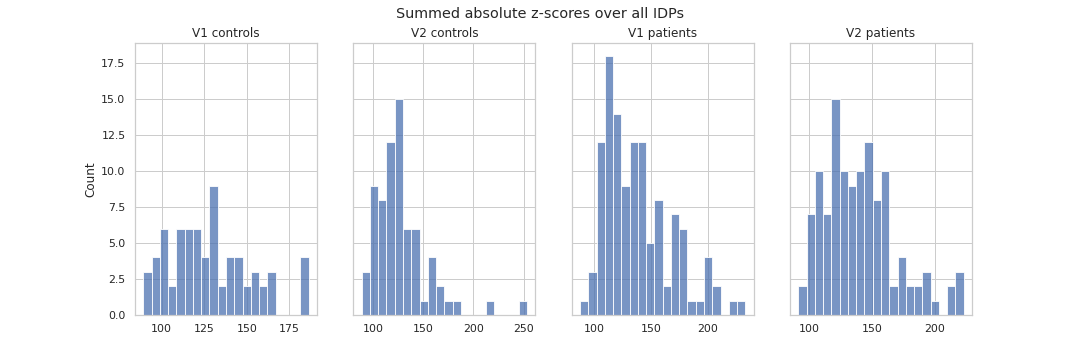

In [70]:
# Identifying controls with the high degree of variability
# To help QC
pk = np.array([np.sum(abs(v1_cont.iloc[:,col_comp_id]), axis=1).to_numpy().T, 
np.sum(abs(v2_cont.iloc[:,col_comp_id]), axis=1).to_numpy().T, 
np.sum(abs(v1_pat.iloc[:,col_comp_id]), axis=1).to_numpy().T,
np.sum(abs(v2_pat.iloc[:,col_comp_id]), axis=1).to_numpy().T], dtype=object)

fig, ax = plt.subplots(1,4, figsize = (15,5), sharey=True)
ax[0].set_title('V1 controls')
sns.histplot(pk[0], ax = ax[0], bins = 20)
ax[1].set_title('V2 controls')
sns.histplot(pk[1], ax = ax[1], bins = 20)
ax[2].set_title('V1 patients')
sns.histplot(pk[2], ax = ax[2], bins = 20)
ax[3].set_title('V2 patients')
sns.histplot(pk[3], ax = ax[3], bins = 20)

fig.suptitle('Summed absolute z-scores over all IDPs')
#sns.heatmap(v1_cont_z)
plt.savefig(os.path.join(models_dir, 'QC_hist.png'))


In [63]:
temp = pd.DataFrame(pk[1], index = v2_cont_z.index)
temp = temp.sort_values(by=[0], ascending = False)

In [100]:
pk2 = v2_pat.iloc[np.where(v2_pat.index == 'P01618')[0],col_comp_id].T
pk2.sort_values(by='P01618', ascending=False)



,P01618
rh_S_oc-temp_lat_thickness,2.301796
rh_S_precentral-inf-part_thickness,1.867125
lh_S_circular_insula_ant_thickness,1.531620
rh_Pole_temporal_thickness,1.473296
Right-Pallidum,1.325519
...,...
Left-Inf-Lat-Vent,-1.118734
Right-Hippocampus,-1.241317
rh_S_temporal_transverse_thickness,-1.338791
rh_S_orbital_med-olfact_thickness,-1.575016


In [442]:
v1_cont.shape

(70, 193)